# Gather Dataset
The dataset will be gathered using Google's iCrawler

In [1]:
from icrawler.builtin import GoogleImageCrawler
import datetime
def datetime2tuple(date):
    return (date.year, date.month, date.day)
def gather_data(n_total_images,n_per_crawl,keyword, folder_name): #collects data by sending google different search queries with different date constraints to mitigate duplicate images
    delta = datetime.timedelta(days=30)
    end_day = datetime.datetime(2023, 3, 17)
    for i in range(int(n_total_images / n_per_crawl )):
        start_day = end_day - delta
        google_crawler = GoogleImageCrawler(downloader_threads=4, storage={'root_dir': folder_name})
        google_crawler.crawl(keyword=keyword[i], filters={'date':(datetime2tuple(start_day), datetime2tuple(end_day))}, file_idx_offset=i*n_per_crawl , max_num=n_per_crawl)
        end_day = start_day - datetime.timedelta(days=1)
#each call gathers data from the query and sends it to its respective directory to be manually cleaned

#gather_data(700,100,['packages ready to ship','packages about to be sent','cardboard boxes','packages','box packages','sealed packages','delivery cardboard package box'],'goodpackages')
#gather_data(200,100,['ripped cardboard boxes','ripped packages'],'rippedpackages') #ripped
#gather_data(200,100,['destroyed packages','damaged cardboard boxes'],'crushedpackages') #crushed
#gather_data(200,100,['cardboard boxes with water damage','wet cardboard boxes'],'leakingpackages')#leaking
#gather_data(200,100,['burned cardboard','charred cardboard'],'burnedpackages') # burned
#gather_data(200,100,['cardboard recycling pile','broken down cardboard boxes'],'foldedpackages')#folded

# Split the Data
After manually cleaning the data, it is ready to be split into testing and training sets.
The different categories of data will be merged into "bad packages" to allow for binary image classification

In [2]:
import splitfolders
import shutil
import os
input_folder = "data\\startingdata\\"
output_folder = "data\\split data\\"
splitfolders.ratio(input_folder, output=output_folder,
                   seed=42, ratio=(.8, 0, .2))
subsets = ['test\\', 'train\\'] 
for subset in subsets: #will be moving images for the training and testing sets
    output = output_folder+subset
    destination = "data\\split data\\"+subset+"\\badpackages\\"
    categories = ['burnedpackages', 'crushedpackages',
                  'foldedpackages', 'leakingpackages', 'rippedpackages']
    for category in categories: #will merge each directory of bad packages into a single one
        source_folder = output + category
        for file_name in os.listdir(source_folder):

            if os.path.exists(destination + '\\' + file_name): #if the already path exists, it renames the new image and moves it
                data = os.path.splitext(file_name)
                only_name = data[0]
                extension = data[1]
                new_base = category + only_name + extension
                new_name = os.path.join(destination, new_base)
                shutil.move(source_folder + '\\' + file_name, new_name)
            else:
                shutil.move(source_folder + '\\' + file_name, #if the path is not already used, the new file will take its place
                            destination + '\\' + file_name)
        os.rmdir(source_folder)


Copying files: 965 files [00:01, 532.35 files/s]


# Processing the Data
The data will be preprocessed using Keras' ImageDataGenerator

In [20]:
from tensorflow.keras.applications.resnet50 import preprocess_input,ResNet50
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

img_height,img_width = (224,224) #the size required by resnet

train_data_path = "data/split data/train/"
test_data_path = "data/split data/test/"

training_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,horizontal_flip=True,validation_split=0.4) 
training_data_generator = training_datagen.flow_from_directory(train_data_path,target_size=(img_height,img_width),class_mode='categorical',subset='training')
testing_data_generator = training_datagen.flow_from_directory(test_data_path,target_size=(img_height,img_width),batch_size=1,class_mode='categorical',subset='validation')


Found 463 images belonging to 2 classes.
Found 77 images belonging to 2 classes.


# Train the Model

In [21]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True #This is required to get around an error thrown by larger images

base_model = ResNet50(include_top=False,weights='imagenet')

output=base_model.output #add new layers to the model
output=GlobalAveragePooling2D()(output) #adds global average pooling - reduces the output of last base model layer to a fixed vector
output=Dense(1024,activation='relu')(output)  
predictions = Dense(training_data_generator.num_classes,activation='softmax')(output)
model = Model(inputs=base_model.input,outputs=predictions) 

for layer in base_model.layers: #freezes all of the weights in the base_model layers
    layer.trainable = False

model.compile(optimizer='adam',loss='binary_crossentropy') 
model.fit(training_data_generator,epochs=20) # trains the newly added layers

c:\Users\willi\anaconda3\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20
15/15 [==============================] - 27s 1s/step - loss: 0.8379
Epoch 2/20
15/15 [==============================] - 24s 2s/step - loss: 0.2571
Epoch 3/20
15/15 [==============================] - 25s 2s/step - loss: 0.1926
Epoch 4/20
15/15 [==============================] - 28s 2s/step - loss: 0.1390
Epoch 5/20
15/15 [==============================] - 26s 2s/step - loss: 0.0945
Epoch 6/20
15/15 [==============================] - 26s 2s/step - loss: 0.0621
Epoch 7/20
15/15 [==============================] - 24s 2s/step - loss: 0.0495
Epoch 8/20
15/15 [==============================] - 23s 2s/step - loss: 0.0421
Epoch 9/20
15/15 [==============================] - 27s 2s/step - loss: 0.0369
Epoch 10/20
15/15 [==============================] - 27s 2s/step - loss: 0.0323
Epoch 11/20
15/15 [==============================] - 25s 2s/step - loss: 0.0208
Epoch 12/20
15/15 [==============================] - 26s 2s/step - loss: 0.0192
Epoch 13/20
15/15 [==============================

# Evaluation

In [24]:
samples = len(testing_data_generator)
predicted = []
actual=[]

for i in range(samples): #runs each sample in the test set
    x,y=testing_data_generator.next() #x is the image and y is the label
    predicted.append((model.predict(x)))
    actual.append(y)


1/1 [==============================] - 0s 113ms/step


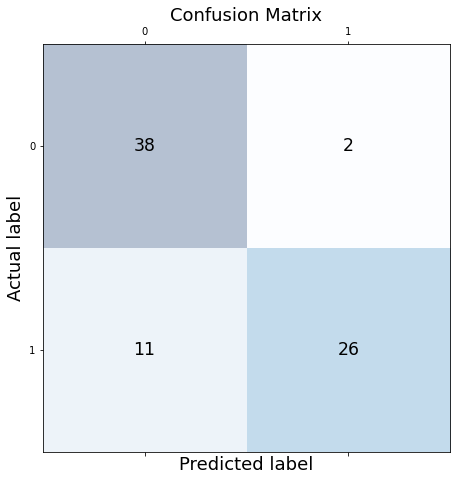

Accuracy: 0.8311688311688312
Precision: 0.95
Recall: 0.7755102040816326
Specificity: 0.9285714285714286
F1-Score: 0.8539325842696629


In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
predicted_class = [i.argmax() for i in predicted]
actual_class = [i.argmax() for i in actual]
conf_matrix = confusion_matrix(actual_class, predicted_class)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('Actual label', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision = (conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[0][1])
recall = (conf_matrix[0][0])/(conf_matrix[0][0]+conf_matrix[1][0])

print("Accuracy:",  (conf_matrix[0][0]+conf_matrix[1][1])/((conf_matrix[0][0]+conf_matrix[0][1])+(conf_matrix[1][0]+conf_matrix[1][1])))
print("Precision:",  precision)
print("Recall:",  recall)
print("Specificity:",  (conf_matrix[1][1])/(conf_matrix[1][1]+conf_matrix[0][1]))
print("F1-Score:",  (2*precision * recall)/(precision+recall))
